In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
BATCH_SIZE = 64
EPOCH = 200

## SRM filter

In [4]:
class SRMLayer(nn.Module):
    def __init__(self):
        super(SRMLayer, self).__init__()
        
        srm_filter = np.array([[-1,  2, -2,  2, -1],
                               [ 2, -6,  8, -6,  2],
                               [-2,  8,-12,  8, -2],
                               [ 2, -6,  8, -6,  2],
                               [-1,  2, -2,  2, -1]])
        
        srm_filter_tensor = torch.tensor(srm_filter, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        srm_filter_tensor = srm_filter_tensor.repeat(1, 3, 1, 1)
        
        self.srm_filter = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=5, stride=1, padding=2, bias=False)
        self.srm_filter.weight = nn.Parameter(srm_filter_tensor)
    
    def forward(self, x):
        return self.srm_filter(x)

## Implementation of the proposed method

In [5]:
class NAVGG(nn.Module):
    def __init__(self):
        super(NAVGG, self).__init__()
        
        self.srm = SRMLayer()
        
        self.vgg = torchvision.models.vgg16()
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.vgg.classifier[6] = nn.Linear(4096, 1)
        
    def forward(self, x):
        out = self.srm(x)
        return self.vgg(out)

In [6]:
model = NAVGG().to(device)

In [7]:
transformer = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    v2.RandomGrayscale(p=0.1),
    v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    
    v2.ToImage(),  
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
dataset = torchvision.datasets.ImageFolder('/kaggle/input/real-and-fake-images/dataset/train', transform=transformer)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
transformer = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6, nesterov=True)
criterion = nn.BCEWithLogitsLoss()

## Training process

In [9]:
for epoch in range(1, EPOCH+1):
    model_loss = 0
    for image, label in dataloader:
        image, label = image.to(device), label.to(device).float()
        
        out = model(image)
        out = out.view(-1)
        loss = criterion(out, label)
        
        model_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    print(f"Epoch: {epoch}\t Model Loss: {model_loss}")

Epoch: 1	 Model Loss: 111.29370880126953
Epoch: 2	 Model Loss: 50.27666473388672
Epoch: 3	 Model Loss: 46.57938003540039
Epoch: 4	 Model Loss: 43.8670768737793
Epoch: 5	 Model Loss: 42.102943420410156
Epoch: 6	 Model Loss: 39.71038055419922
Epoch: 7	 Model Loss: 39.098236083984375
Epoch: 8	 Model Loss: 38.12850570678711
Epoch: 9	 Model Loss: 37.29909133911133
Epoch: 10	 Model Loss: 36.02924346923828
Epoch: 11	 Model Loss: 35.57667922973633
Epoch: 12	 Model Loss: 35.17872619628906
Epoch: 13	 Model Loss: 33.98767852783203
Epoch: 14	 Model Loss: 34.12541961669922
Epoch: 15	 Model Loss: 33.65521240234375
Epoch: 16	 Model Loss: 32.3294563293457
Epoch: 17	 Model Loss: 32.30155944824219
Epoch: 18	 Model Loss: 31.934608459472656
Epoch: 19	 Model Loss: 31.57101821899414
Epoch: 20	 Model Loss: 31.044187545776367
Epoch: 21	 Model Loss: 30.491077423095703
Epoch: 22	 Model Loss: 30.12449073791504
Epoch: 23	 Model Loss: 29.67723274230957
Epoch: 24	 Model Loss: 29.316144943237305
Epoch: 25	 Model Los

KeyboardInterrupt: 

In [8]:
model.load_state_dict(torch.load("/kaggle/input/chang-method/pytorch/default/1/new_model.pth", weights_only=True))

<All keys matched successfully>

In [9]:
dataset = torchvision.datasets.ImageFolder("/kaggle/input/real-and-fake-images/dataset/validation", transform=transformer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Validation process

In [10]:
model.eval()

correct = 0
total = 0
validation_loss = 0

criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for image, label in dataloader:
        image, label = image.to(device), label.to(device).float()
        
        out = model(image)
        out = out.view(-1)
        
        loss = criterion(out, label)
        validation_loss += loss.item()
        
        predicted = torch.sigmoid(out) > 0.5
        
        correct += (predicted == label).sum().item()
        total += label.size(0)

# Calcular e exibir métricas
accuracy = 100 * correct / total
print(f'Validation Loss: {validation_loss:.4f}')
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Loss: 43.8089
Validation Accuracy: 80.12%


In [11]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for image, label in dataloader:
        image, label = image.to(device), label.to(device).float()
        
        out = model(image).view(-1)            # logits
        probs = torch.sigmoid(out)             # probabilidades entre 0 e 1
        preds = (probs > 0.5).long()           # 0 ou 1
        
        all_preds.append(preds.cpu())
        all_labels.append(label.cpu().long())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()


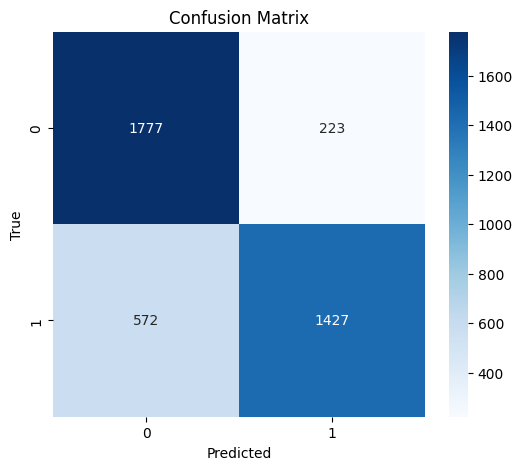

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')  # ou 'macro', 'micro' dependendo do que quiser
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.8107
Recall: 0.8012
F1-score: 0.7997
